# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* **PEFT technique:** LoRA (Low-Rank Adaptation) – chosen because it is lightweight, parameter-efficient, compatible with sequence classification, and works well with smaller models like DistilBERT.  
* **Model:** `distilbert-base-uncased` – a small, pretrained transformer suitable for text classification tasks; it balances performance and resource usage, making it ideal for workspace constraints.  
* **Evaluation approach:** Hugging Face `Trainer` with metrics `accuracy` and `F1` – allows straightforward evaluation of classification performance before and after fine-tuning, providing direct comparison between models.  
* **Fine-tuning dataset:** IMDB movie reviews dataset from Hugging Face (`datasets.load_dataset("imdb")`) – a binary sentiment classification dataset; a subset is used to reduce computational requirements while still demonstrating fine-tuning effectiveness.


In [1]:
!pip install transformers datasets evaluate peft matplotlib --quiet

In [2]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, PeftModel
import evaluate
import matplotlib.pyplot as plt

# Detect if CUDA is available
use_cuda = torch.cuda.is_available()
print("CUDA available:", use_cuda)

CUDA available: False


## 1. Load Pretrained Model and Tokenizer

In [3]:
model_name = "distilbert-base-uncased"
num_labels = 2  # binary classification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 2. Load and Tokenize Dataset

In [4]:
dataset = load_dataset("imdb")

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])
tokenized_dataset.set_format('torch')

## 3. Evaluate Original Model

In [5]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return {
        'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
        'f1': f1.compute(predictions=predictions, references=labels)['f1']
    }

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_dataset['test'].shuffle().select(range(500)),
    compute_metrics=compute_metrics
)

original_eval = trainer.evaluate()
print("Original model performance:", original_eval)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Original model performance: {'eval_loss': 0.6987777352333069, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.508, 'eval_f1': 0.0, 'eval_runtime': 8.1274, 'eval_samples_per_second': 61.52, 'eval_steps_per_second': 3.937}


## 4. Define LoRA Configurations

In [6]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(name)

distilbert.transformer.layer.0.attention.q_lin
distilbert.transformer.layer.0.attention.k_lin
distilbert.transformer.layer.0.attention.v_lin
distilbert.transformer.layer.0.attention.out_lin
distilbert.transformer.layer.0.ffn.lin1
distilbert.transformer.layer.0.ffn.lin2
distilbert.transformer.layer.1.attention.q_lin
distilbert.transformer.layer.1.attention.k_lin
distilbert.transformer.layer.1.attention.v_lin
distilbert.transformer.layer.1.attention.out_lin
distilbert.transformer.layer.1.ffn.lin1
distilbert.transformer.layer.1.ffn.lin2
distilbert.transformer.layer.2.attention.q_lin
distilbert.transformer.layer.2.attention.k_lin
distilbert.transformer.layer.2.attention.v_lin
distilbert.transformer.layer.2.attention.out_lin
distilbert.transformer.layer.2.ffn.lin1
distilbert.transformer.layer.2.ffn.lin2
distilbert.transformer.layer.3.attention.q_lin
distilbert.transformer.layer.3.attention.k_lin
distilbert.transformer.layer.3.attention.v_lin
distilbert.transformer.layer.3.attention.out_lin


In [7]:
lora_configs = [
    LoraConfig(r=4, lora_alpha=16, target_modules=["q_lin", "v_lin", "k_lin", "output_lin"], lora_dropout=0.05, bias="none", task_type="SEQ_CLS"),
    LoraConfig(r=8, lora_alpha=32, target_modules=["q_lin", "v_lin", "k_lin", "output_lin"], lora_dropout=0.1, bias="none", task_type="SEQ_CLS")
]

## 5. Train and Save LoRA Models

In [8]:
results_dict = {}
train_subset = tokenized_dataset['train'].shuffle().select(range(1000))
eval_subset = tokenized_dataset['test'].shuffle().select(range(500))

for i, config in enumerate(lora_configs):
    print(f"\nTraining LoRA model {i+1}...")
    peft_model = get_peft_model(model, config)
    trainer = Trainer(
        model=peft_model,
        args=TrainingArguments(
            output_dir=f"./lora_results_{i}",
            learning_rate=5e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=1,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_dir=f"./logs_{i}"
        ),
        train_dataset=train_subset,
        eval_dataset=eval_subset,
        compute_metrics=compute_metrics
    )
    trainer.train()
    peft_model.save_pretrained(f"./lora_model_{i}")
    results_dict[f'LoRA_{i}'] = trainer.evaluate()


Training LoRA model 1...
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.670320,0.676000,0.539773


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training LoRA model 2...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.640400,0.776000,0.741935


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


## 6. Performing Inference with a PEFT Model (Saved LoRA Model)
This simulates using the model in the future. We load the saved LoRA adapters and perform inference on test samples.

In [11]:
from peft import AutoPeftModelForSequenceClassification
from transformers import pipeline

lora_loaded = AutoPeftModelForSequenceClassification.from_pretrained("./lora_model_1", num_labels=num_labels)
lora_loaded.eval()

lora_pipeline = pipeline(
    "text-classification",
    model=lora_loaded,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

test_samples = dataset['test'].shuffle().select(range(10))

print("=== LoRA Fine-Tuned Model Predictions (Loaded from Saved) ===")
for sample in test_samples:
    text = sample['text'][:512]
    result = lora_pipeline(text)[0]
    print(f"{text[:60]}...\n→ Label: {result['label']} | Score: {result['score']:.4f}\n")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


=== LoRA Fine-Tuned Model Predictions (Loaded from Saved) ===
An obvious cash-in on the *Insert Monster Here* On A Plane g...
→ Label: LABEL_0 | Score: 0.5375

This Movie Is Excellent The passion between Jade & Billy is ...
→ Label: LABEL_1 | Score: 0.5791

The first DH wasn't that great, but I really didn't expect i...
→ Label: LABEL_0 | Score: 0.5833

I've seen "professional" reviews claiming Julia Roberts play...
→ Label: LABEL_0 | Score: 0.5614

This movie is well made, it is beautiful and wise. It is hea...
→ Label: LABEL_1 | Score: 0.5997

Makes "Invasion USA" look like "Apocalypse Now". This one ca...
→ Label: LABEL_0 | Score: 0.5774

Deep Sea 3D is a stunning insight in to an underwater world ...
→ Label: LABEL_1 | Score: 0.5658

The Elegant Documentary -<br /><br />Don't watch this movie ...
→ Label: LABEL_0 | Score: 0.5674

OK I for one thought the trailer was quite good so was hopef...
→ Label: LABEL_0 | Score: 0.5434

I love Movies that take you into them. A movie that actu

## 7. Optional QLoRA (8-bit + LoRA) on GPU Only

In [12]:
if use_cuda:
    from peft import AutoPeftModelForSequenceClassification
    print("Running QLoRA...")

    quant_model = AutoPeftModelForSequenceClassification.from_pretrained(
        model_name,
        load_in_8bit=True,
        device_map="auto",
        num_labels=num_labels
    )

    qlora_config = LoraConfig(r=8, lora_alpha=32, target_modules=["Linear"], lora_dropout=0.1, bias="none", task_type="SEQ_CLS")
    qlora_model = get_peft_model(quant_model, qlora_config)

    trainer = Trainer(
        model=qlora_model,
        args=TrainingArguments(
            output_dir="./qlora_results",
            learning_rate=5e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=1,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_dir='./qlora_logs'
        ),
        train_dataset=train_subset,
        eval_dataset=eval_subset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    qlora_model.save_pretrained("./qlora_model")
    results_dict['QLoRA'] = trainer.evaluate()
else:
    print("CUDA not available. Skipping QLoRA.")

CUDA not available. Skipping QLoRA.


## 8. Compare All Models

LoRA_0: {'eval_loss': 0.6703202128410339, 'eval_accuracy': 0.676, 'eval_f1': 0.5397727272727273, 'eval_runtime': 9.0742, 'eval_samples_per_second': 55.101, 'eval_steps_per_second': 3.526, 'epoch': 1.0}
LoRA_1: {'eval_loss': 0.6403995156288147, 'eval_accuracy': 0.776, 'eval_f1': 0.7419354838709677, 'eval_runtime': 8.8281, 'eval_samples_per_second': 56.638, 'eval_steps_per_second': 3.625, 'epoch': 1.0}
Original: {'eval_loss': 0.6987777352333069, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.508, 'eval_f1': 0.0, 'eval_runtime': 8.1274, 'eval_samples_per_second': 61.52, 'eval_steps_per_second': 3.937}


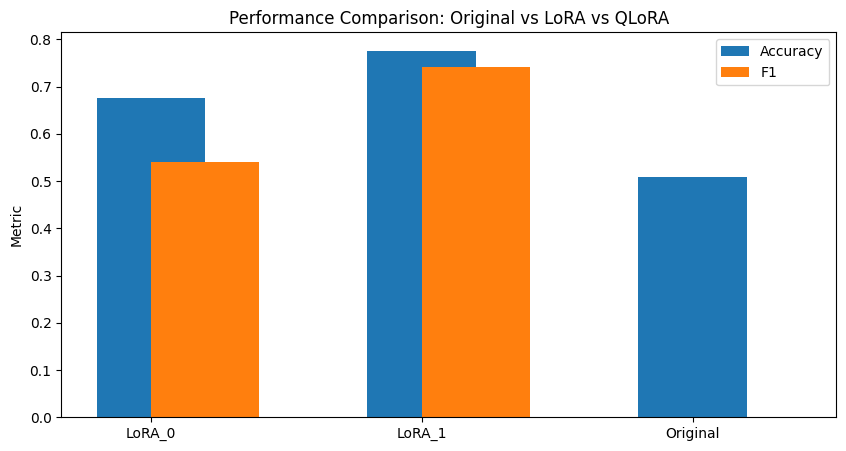

In [13]:
results_dict['Original'] = original_eval

for model_name, metrics in results_dict.items():
    print(f"{model_name}: {metrics}")

# Plot comparison
labels = list(results_dict.keys())
accuracy_vals = [results_dict[m]['eval_accuracy'] for m in labels]
f1_vals = [results_dict[m]['eval_f1'] for m in labels]

x = range(len(labels))
plt.figure(figsize=(10,5))
plt.bar(x, accuracy_vals, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1_vals, width=0.4, label='F1', align='edge')
plt.xticks(x, labels)
plt.ylabel('Metric')
plt.title('Performance Comparison: Original vs LoRA vs QLoRA')
plt.legend()
plt.show()